# ML1 Practical 6: Model Selection & Evaluation

## Example: Logistic Regression with Polynomial Features
In the following plot, we see a function $f(x) = cos(\frac{3}{2}\pi x)$
and some noisy samples from that function. We use three different estimators to fit the function: linear regression with polynomial features of degree 1, 4 and 15. We see that the first estimator can at best provide only a poor fit to the samples and the true function because it is too simple (high bias), the second estimator approximates it almost perfectly and the last estimator approximates the training data perfectly but does not fit the true function very well, i.e. it is very sensitive to varying training data (high variance).

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score


def true_fun(X):
    return np.cos(1.5 * np.pi * X)


def generate_dataset(n_samples=30):
    np.random.seed(0)
    X = np.sort(np.random.rand(n_samples))
    y = true_fun(X) + np.random.randn(n_samples) * 0.1
    return X, y

X, y = generate_dataset()

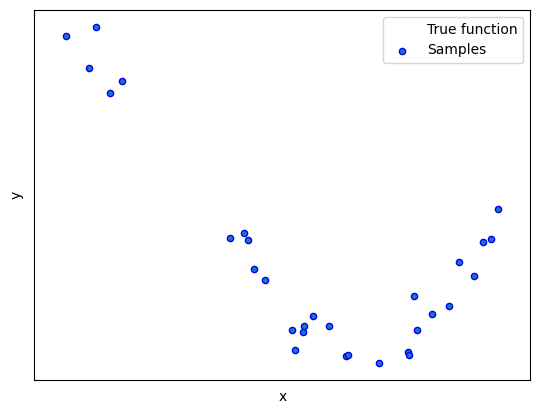

In [3]:
xs = np.linspace(0., 1., 100)
ax = plt.gca()
plt.setp(ax, xticks=(), yticks=())
plt.plot(xs, true_fun(xs), c='C1', label='True function', alpha=0.0, ls='--')
plt.scatter(X, y,edgecolor="b", s=20, label="Samples")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

This example demonstrates the problems of underfitting and overfitting and how we can use linear regression with polynomial features to approximate nonlinear functions. The plot shows the function that we want to approximate, which is a part of the cosine function. In addition, the samples from the real function and the approximations of different models are displayed. The models have polynomial features of different degrees. We can see that a linear function (polynomial with degree 1) is not sufficient to fit the training samples. This is called **underfitting**. A polynomial of degree 4 approximates the true function almost perfectly. However, for higher degrees the model will **overfit** the training data, i.e. it learns the noise of the training data. We evaluate quantitatively **overfitting / underfitting** by using cross-validation. We calculate the mean squared error (MSE) on the validation set, the higher, the less likely the model generalizes correctly from the training data.

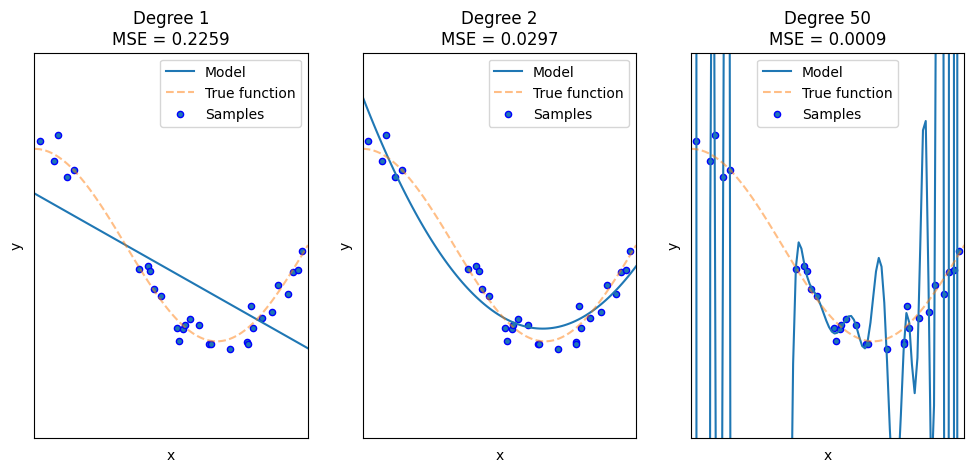

In [4]:
from sklearn.metrics import mean_squared_error
degrees = [1, 2, 50]
plt.figure(figsize=(4 * len(degrees), 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline(
        [
            ("polynomial_features", polynomial_features),
            ("linear_regression", linear_regression),
        ]
    )
    pipeline.fit(X[:, np.newaxis], y)
    y_pred = pipeline.predict(X[:, np.newaxis])
    scores = mean_squared_error(y, y_pred)

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function", alpha=0.5, ls='--')
    plt.scatter(X, y, edgecolor="b", s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title(
        "Degree {}\nMSE = {:.4f}".format(
            degrees[i], scores
        )
    )
plt.show()

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
X, y = datasets.load_iris(return_X_y=True)

We can now quickly sample a training set while holding out 20% of the data for testing (evaluating) our classifier:

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [7]:
print(f"X_train.shape: {X_train.shape}")
print(f"X_test.shape:  {X_test.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"y_test.shape:  {y_test.shape}")

X_train.shape: (120, 4)
X_test.shape:  (30, 4)
y_train.shape: (120,)
y_test.shape:  (30,)


When evaluating different settings (“hyperparameters”) for estimators, such as the degree setting that must be manually set for Linear Regression with polynomial features, there is still a risk of overfitting on the test set because the parameters can be tweaked until the estimator performs optimally. This way, knowledge about the test set can “leak” into the model and evaluation metrics no longer report on generalization performance. To solve this problem, yet another part of the dataset can be held out as a so-called “validation set”: training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the test set.

However, by partitioning the available data into three sets, we drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets.

A solution to this problem is a procedure called cross-validation (CV for short). A test set should still be held out for final evaluation, but the validation set is no longer needed when doing CV. In the basic approach, called k-fold CV, the training set is split into k smaller sets (other approaches are described below, but generally follow the same principles). The following procedure is followed for each of the k “folds”:

- A model is trained using $k-1$ of the folds as training data;
- the resulting model is validated on the remaining part of the data (i.e., it is used as a test set to compute a performance measure such as accuracy).

The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop. This approach can be computationally expensive, but does not waste too much data (as is the case when fixing an arbitrary validation set), which is a major advantage in problems such as inverse inference where the number of samples is very small.

<img src='grid_search_cross_validation.png' width='500px'/>

## Example: Linear Regression with Polynomial Features cont'
The simplest way to use cross-validation is to call the `cross_val_score` helper function on the estimator and the dataset.

The following example demonstrates how to estimate the accuracy of logistic regression on our dataset by splitting the data, fitting a model and computing the score 5 consecutive times (with different splits each time):

In [8]:
X, y = generate_dataset()
clf = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
scores = cross_val_score(clf, X_train[:, None], y_train, cv=5)
scores.mean()

-0.372135740557323

Bias and variance are inherent properties of estimators and we usually have to select learning algorithms and hyperparameters so that both bias and variance are as low as possible. Another way to reduce the variance of a model is to use more training data. However, you should only collect more training data if the true function is too complex to be approximated by an estimator with a lower variance.

In the simple one-dimensional problem that we have seen in the example it is easy to see whether the estimator suffers from bias or variance. However, in high-dimensional spaces, models can become very difficult to visualize.

## Validation curve
To validate a model we need a scoring function, for example accuracy for classifiers. The proper way of choosing multiple hyperparameters of an estimator is of course grid search or similar methods that select the hyperparameter with the maximum score on a validation set or multiple validation sets. Note that if we optimize the hyperparameters based on a validation score the validation score is biased and not a good estimate of the generalization any longer. To get a proper estimate of the generalization we have to compute the score on another test set.

However, it is sometimes helpful to plot the influence of a single hyperparameter on the training score and the validation score to find out whether the estimator is overfitting or underfitting for some hyperparameter values.

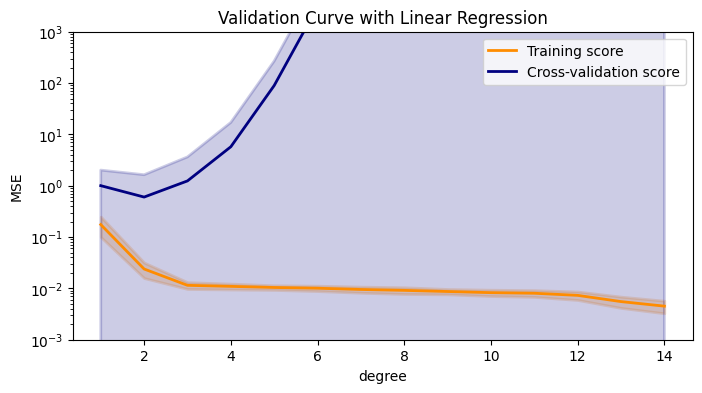

In [9]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import cross_validate

param_range = np.arange(1, 15)

train_scores = []
test_scores = []
for degree in param_range:
    polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline(
        [
            ("polynomial_features", polynomial_features),
            ("linear_regression", linear_regression),
        ]
    )
    result = cross_validate(pipeline, X[:, np.newaxis], y, return_train_score=True, scoring='neg_mean_squared_error', cv=5)
    train_scores.append(result['train_score'])
    test_scores.append(result['test_score'])
train_scores = np.asarray(train_scores)
test_scores = np.asarray(test_scores)

train_scores_mean = np.mean(-train_scores, axis=1)
train_scores_std = np.std(-train_scores, axis=1)
test_scores_mean = np.mean(-test_scores, axis=1)
test_scores_std = np.std(-test_scores, axis=1)

plt.figure(figsize=(8, 4))
plt.title("Validation Curve with Linear Regression")
plt.xlabel(r"degree")
plt.ylabel("MSE")
plt.ylim(10.**-3, 10.**3)
plt.yscale('log')
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.plot(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.show()

# Metrics
## Classification Metrics
The `sklearn.metrics` module implements several loss, score, and utility functions to measure classification performance. Some metrics might require probability estimates of the positive class, confidence values, or binary decisions values. Most implementations allow each sample to provide a weighted contribution to the overall score, through the `sample_weight` parameter.
### Accuracy score
The `accuracy_score` function computes the accuracy, either the fraction (default) or the count (normalize=False) of correct predictions.

If $\hat{y}_i$ is the predicted value of the $i$-th sample and $y_i$ is the corresponding true value, then the fraction of correct predictions over $n_\mathrm{samples}$ is defined as
$$ \frac{1}{n_\mathrm{samples}} \sum_{i=0}^{n_\mathrm{samples} - 1} \mathbb{1}(\hat{y}_i = y_i)$$
where $\mathbb{1}(\cdot)$ is the indicator function.

In [10]:
import numpy as np
from sklearn.metrics import accuracy_score
y_pred = [0, 2, 1, 3]
y_true = [0, 1, 2, 3]
accuracy_score(y_true, y_pred)

0.5

### Top-k accuracy score
The `top_k_accuracy_score` function is a generalization of accuracy_score. The difference is that a prediction is considered correct as long as the true label is associated with one of the `k` highest predicted scores. `accuracy_score` is the special case of `k = 1`.

In [11]:
from sklearn.metrics import top_k_accuracy_score
y_true = np.array([0, 1, 2, 2])
y_score = np.array([[0.5, 0.2, 0.2],
                    [0.3, 0.4, 0.2],
                    [0.2, 0.4, 0.3],
                    [0.7, 0.2, 0.1]])
top_k_accuracy_score(y_true, y_score, k=2)

0.75

### Confusion Matrix
The `confusion_matrix` function evaluates classification accuracy by computing the confusion matrix with each row corresponding to the true class (Wikipedia and other references may use different convention for axes).

By definition, entry $i,j$ in a confusion matrix is the number of observations actually in group $i$, but predicted to be in group $j$. Here is an example:

In [12]:
from sklearn.metrics import confusion_matrix
y_true = [2, 0, 2, 2, 0, 1]
y_pred = [0, 0, 2, 2, 0, 2]
confusion_matrix(y_true, y_pred)

array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])

Confusion matrix, without normalization
[[13  0  0]
 [ 0  3 13]
 [ 0  0  9]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.   0.19 0.81]
 [0.   0.   1.  ]]


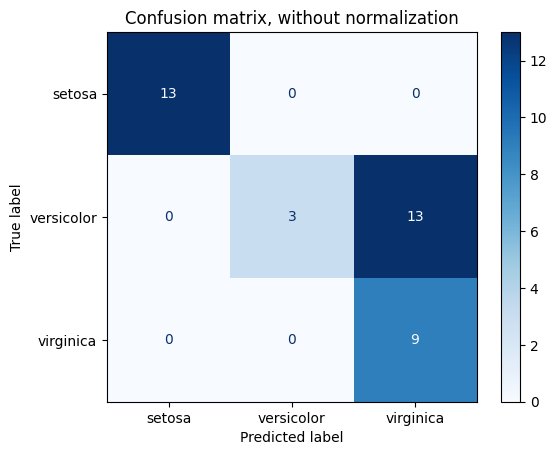

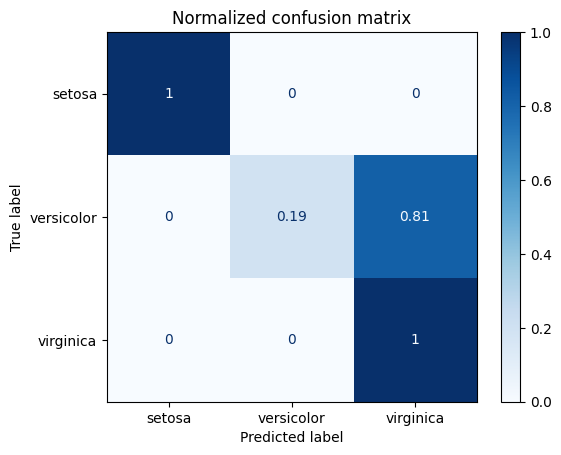

In [13]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

# import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = linear_model.LogisticRegression(C=0.01).fit(X_train, y_train)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        classifier,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()




### Precision-Recall
<img src='Precisionrecall.svg.png' width=40%/>
Example of Precision-Recall metric to evaluate classifier output quality.

Precision-Recall is a useful measure of success of prediction when the
classes are very imbalanced. In information retrieval, precision is a
measure of result relevancy, while recall is a measure of how many truly
relevant results are returned.

The precision-recall curve shows the tradeoff between precision and
recall for different threshold. A high area under the curve represents
both high recall and high precision, where high precision relates to a
low false positive rate, and high recall relates to a low false negative
rate. High scores for both show that the classifier is returning accurate
results (high precision), as well as returning a majority of all positive
results (high recall).

A system with high recall but low precision returns many results, but most of
its predicted labels are incorrect when compared to the training labels. A
system with high precision but low recall is just the opposite, returning very
few results, but most of its predicted labels are correct when compared to the
training labels. An ideal system with high precision and high recall will
return many results, with all results labeled correctly.

Precision ($P$) is defined as the number of true positives ($T_p$)
over the number of true positives plus the number of false positives
($F_p$).

$P = \frac{T_p}{T_p+F_p}$

Recall ($R$) is defined as the number of true positives ($T_p$)
over the number of true positives plus the number of false negatives
($F_n$).

$R = \frac{T_p}{T_p + F_n}$

These quantities are also related to the ($F_1$) score, which is defined
as the harmonic mean of precision and recall.

$F1 = 2\frac{P \times R}{P+R}$

Note that the precision may not decrease with recall. The
definition of precision ($\frac{T_p}{T_p + F_p}$) shows that lowering
the threshold of a classifier may increase the denominator, by increasing the
number of results returned. If the threshold was previously set too high, the
new results may all be true positives, which will increase precision. If the
previous threshold was about right or too low, further lowering the threshold
will introduce false positives, decreasing precision.

Recall is defined as $\frac{T_p}{T_p+F_n}$, where $T_p+F_n$ does
not depend on the classifier threshold. This means that lowering the classifier
threshold may increase recall, by increasing the number of true positive
results. It is also possible that lowering the threshold may leave recall
unchanged, while the precision fluctuates.

The relationship between recall and precision can be observed in the
stairstep area of the plot - at the edges of these steps a small change
in the threshold considerably reduces precision, with only a minor gain in
recall.

**Average precision** (AP) summarizes such a plot as the weighted mean of
precisions achieved at each threshold, with the increase in recall from the
previous threshold used as the weight:

$\text{AP} = \sum_n (R_n - R_{n-1}) P_n$

where $P_n$ and $R_n$ are the precision and recall at the
nth threshold. A pair $(R_k, P_k)$ is referred to as an
*operating point*.

Precision-recall curves are typically used in binary classification to study
the output of a classifier. In order to extend the precision-recall curve and
average precision to multi-class or multi-label classification, it is necessary
to binarize the output. One curve can be drawn per label, but one can also draw
a precision-recall curve by considering each element of the label indicator
matrix as a binary prediction (micro-averaging).


In [14]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

X, y = load_iris(return_X_y=True)

# Add noisy features
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.concatenate([X, random_state.randn(n_samples, 200 * n_features)], axis=1)

# Limit to the two first classes, and split into training and test
X_train, X_test, y_train, y_test = train_test_split(
    X[y < 2], y[y < 2], test_size=0.5, random_state=random_state
)

In [15]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

classifier = make_pipeline(StandardScaler(), LogisticRegression(random_state=random_state))
classifier.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(random_state=RandomState(MT19937) at 0x7F3542EA65A0))])

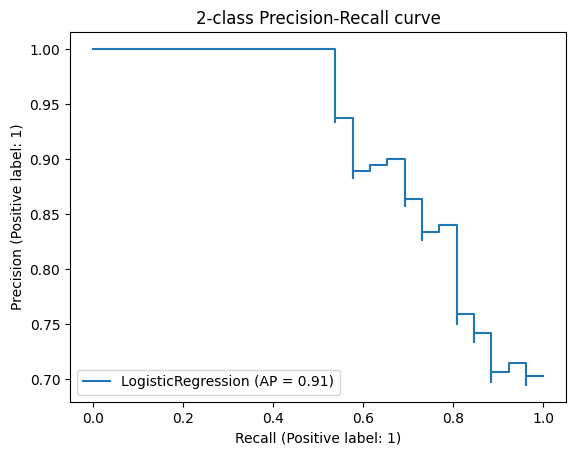

In [16]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    classifier, X_test, y_test, name="LogisticRegression"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

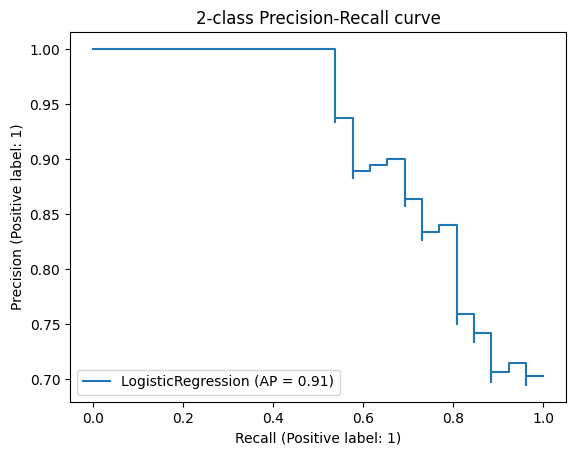

In [17]:
y_score = classifier.decision_function(X_test)

display = PrecisionRecallDisplay.from_predictions(y_test, y_score, name="LogisticRegression")
_ = display.ax_.set_title("2-class Precision-Recall curve")

## Regression Metrics
### Mean squared error
The `mean_squared_error` function computes mean square error, a risk metric corresponding to the expected value of the squared (quadratic) error or loss.

If $\hat{y}_i$
is the predicted value of the $i$-th sample, and $y_i$ is the corresponding true value, then the mean squared error (MSE) estimated over $n_\mathrm{samples}$ is defined as

$$ \frac{1}{n_\mathrm{samples}} \sum_{i=0}^{n_\mathrm{samples}-1} (y_i - \hat{y}_i)^2 $$

In [18]:
from sklearn.metrics import mean_squared_error
y_true = [3, -0.5, 2, 7]
y_pred = [2.5, 0.0, 2, 8]
mean_squared_error(y_true, y_pred)

0.375

# Hyperparameter Optimization
Hyper-parameters are parameters that are not directly learnt within estimators. In scikit-learn they are passed as arguments to the constructor of the estimator classes. Typical examples include `C`, `kernel` and `gamma` for Support Vector Classifier, `alpha` for Lasso, etc.

It is possible and recommended to search the hyper-parameter space for the best cross validation score.

Any parameter provided when constructing an estimator may be optimized in this manner. 

A search consists of:

- an estimator (regressor or classifier such as sklearn.svm.SVC());
- a parameter space;
- a method for searching or sampling candidates;
- a cross-validation scheme; and
- a score function.

Two generic approaches to parameter search are provided in scikit-learn: for given values, `GridSearchCV` exhaustively considers all parameter combinations, while `RandomizedSearchCV` can sample a given number of candidates from a parameter space with a specified distribution.

## GridSearchCV
The grid search provided by `GridSearchCV` exhaustively generates candidates from a grid of parameter values specified with the `param_grid` parameter. For instance, the following `param_grid`:

In [19]:
X, y = generate_dataset()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

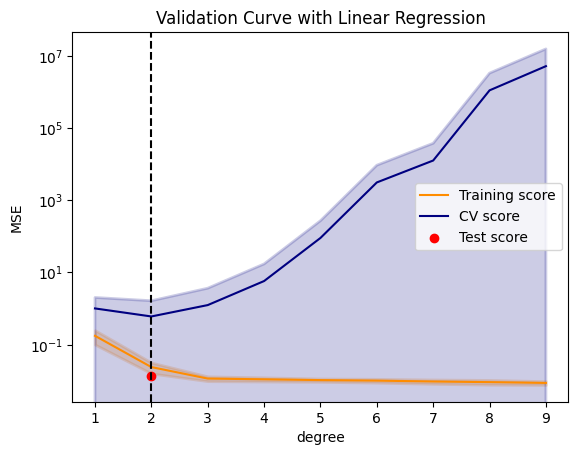

In [20]:
from sklearn.model_selection import GridSearchCV

polynomial_features = PolynomialFeatures(include_bias=False)
linear_regression = LinearRegression()
pipeline = Pipeline(
    [
        ("polynomial_features", polynomial_features),
        ("linear_regression", linear_regression),
    ]
)
degrees = np.arange(1, 10)
param_grid = [
    {'polynomial_features__degree': degrees}
]

clf = GridSearchCV(pipeline, param_grid, cv=5, return_train_score=True, scoring='neg_mean_squared_error')
clf.fit(X[:, None], y)

mean_train_score = -clf.cv_results_['mean_train_score']
mean_test_score = -clf.cv_results_['mean_test_score']
std_train_score = clf.cv_results_['std_train_score']
std_test_score = clf.cv_results_['std_test_score']

plt.plot(degrees, mean_train_score, color='darkorange', label='Training score')
plt.fill_between(
    degrees,
    mean_train_score - std_train_score,
    mean_train_score + std_train_score,
    alpha=0.2,
    color="darkorange",
    lw=2,
)
plt.plot(degrees, mean_test_score, color='navy', label='CV score')
plt.fill_between(
    degrees,
    mean_test_score - std_test_score,
    mean_test_score + std_test_score,
    alpha=0.2,
    color="navy",
    lw=2,
)

best_degree = clf.best_params_['polynomial_features__degree']
test_score = -clf.score(X_test[:, None], y_test)
plt.axvline(best_degree, c='k', ls='--')
plt.scatter(best_degree, test_score, c='r', label='Test score')

plt.xlabel('degree')
plt.ylabel('MSE')
plt.yscale('log')
plt.legend()
plt.title("Validation Curve with Linear Regression")
plt.show()

## Random Search
<img src='HPO1.png' width=75%/>

/home/horst2204/miniconda3/envs/synch_dynapse/lib/python3.7/site-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


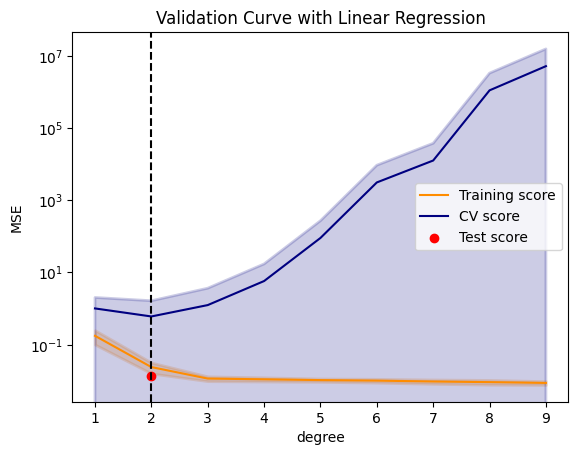

In [21]:
from sklearn.model_selection import RandomizedSearchCV

polynomial_features = PolynomialFeatures(include_bias=False)
linear_regression = LinearRegression()
pipeline = Pipeline(
    [
        ("polynomial_features", polynomial_features),
        ("linear_regression", linear_regression),
    ]
)
degrees = np.arange(1, 10)
param_grid = [
    {'polynomial_features__degree': degrees}
]

clf = RandomizedSearchCV(pipeline, param_grid, cv=5, return_train_score=True, scoring='neg_mean_squared_error')
clf.fit(X[:, None], y)

mean_train_score = -clf.cv_results_['mean_train_score']
mean_test_score = -clf.cv_results_['mean_test_score']
std_train_score = clf.cv_results_['std_train_score']
std_test_score = clf.cv_results_['std_test_score']

plt.plot(degrees, mean_train_score, color='darkorange', label='Training score')
plt.fill_between(
    degrees,
    mean_train_score - std_train_score,
    mean_train_score + std_train_score,
    alpha=0.2,
    color="darkorange",
    lw=2,
)
plt.plot(degrees, mean_test_score, color='navy', label='CV score')
plt.fill_between(
    degrees,
    mean_test_score - std_test_score,
    mean_test_score + std_test_score,
    alpha=0.2,
    color="navy",
    lw=2,
)

best_degree = clf.best_params_['polynomial_features__degree']
test_score = -clf.score(X_test[:, None], y_test)
plt.axvline(best_degree, c='k', ls='--')
plt.scatter(best_degree, test_score, c='r', label='Test score')

plt.xlabel('degree')
plt.ylabel('MSE')
plt.yscale('log')
plt.legend()
plt.title("Validation Curve with Linear Regression")
plt.show()

## Further Reading
- https://github.com/FacebookResearch/Nevergrad